#  Content-Based Information Retrieval

In [1]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from keras.models import save_model
import keras

In [2]:
class ModelSaveCallback(keras.callbacks.Callback):

    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))


# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

# Dataset

In [3]:
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (50000, 32, 32, 3) (50000, 1)
Test samples: (10000, 32, 32, 3) (10000, 1)


In [5]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

In [6]:
'''# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()'''

"# show random images from train\ncols = 8\nrows = 2\nfig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))\nfor i in range(cols):\n    for j in range(rows):\n        random_index = np.random.randint(0, len(y_train))\n        ax = fig.add_subplot(rows, cols, i * rows + j + 1)\n        ax.grid('off')\n        ax.axis('off')\n        ax.imshow(x_train[random_index, :])\n        ax.set_title(cifar10_classes[y_train[random_index, 0]])\nplt.show()"

In [7]:
'''x_train = x_train.astype('float32') / 255.0 - 0.5
x_test = x_test.astype('float32') / 255.0 - 0.5

noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=0.3, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=0.3, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)'''

"x_train = x_train.astype('float32') / 255.0 - 0.5\nx_test = x_test.astype('float32') / 255.0 - 0.5\n\nnoise_factor = 0.3\nx_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=0.3, size=x_train.shape)\nx_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=0.3, size=x_test.shape)\n\nx_train_noisy = np.clip(x_train_noisy, 0., 1.)\nx_test_noisy = np.clip(x_test_noisy, 0., 1.)"

In [8]:
#x_train = x_train.astype('float32') / 255.0 - 0.5
#x_test = x_test.astype('float32') / 255.0 - 0.5

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

def add_noise_and_clip_data(data):
   noise = np.random.normal(loc=0.0, scale=0.1, size=data.shape)
   data = data + noise
   data = np.clip(data, 0., 1.)
   return data

x_train_noisy = add_noise_and_clip_data(x_train)
x_test_noisy = add_noise_and_clip_data(x_test)

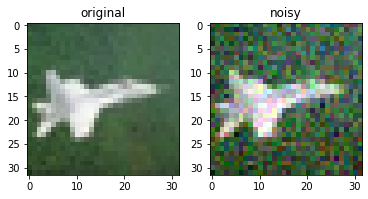

In [104]:
idx = 77
plt.subplot(1,2,1)
plt.imshow(x_train[idx])
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(x_train_noisy[idx])
plt.title('noisy')
#plt.subplot(1,3,3)
#plt.imshow(test_data_denoised[idx])
#plt.title('denoised')
plt.show()

In [11]:

IMG_SHAPE = x_train.shape[1:]

# center images
#x_train = x_train.astype('float32') / 255.0 - 0.5
#x_test = x_test.astype('float32') / 255.0 - 0.5

# Model

In [12]:
def build_deep_autoencoder(img_shape, code_size):
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    encoder.add(L.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size)) 
#     encoder.summary()

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    decoder.add(L.Dense(2*2*256))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape((2,2,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='relu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [68]:
#encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

In [14]:
inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [15]:
#model_filename = 'autoencoder.{0:03d}.hdf5'
#last_finished_epoch = 23

### uncomment below to continue training from model checkpoint
### fill `last_finished_epoch` with your latest finished epoch
#from keras.models import load_model
#s = reset_tf_session()
# last_finished_epoch = 4
#autoencoder = load_model(model_filename.format(last_finished_epoch))
#encoder = autoencoder.layers[1]
#decoder = autoencoder.layers[2]

# Training

In [16]:
encoder = autoencoder.layers[1]
decoder = autoencoder.layers[2]

In [17]:
#model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = 0
autoencoder.fit(x=x_train_noisy, y=x_train, epochs=20,
                validation_data=[x_test_noisy, x_test],
                verbose=1)

Epoch 1/20
1563/1563 [==============================] - 238s 152ms/step - loss: 0.0269 - val_loss: 0.0000e+00
Epoch 2/20
1563/1563 [==============================] - 236s 151ms/step - loss: 0.0151 - val_loss: 0.0000e+00
Epoch 3/20
1563/1563 [==============================] - 235s 150ms/step - loss: 0.0135 - val_loss: 0.0000e+00
Epoch 4/20
1563/1563 [==============================] - 236s 151ms/step - loss: 0.0131 - val_loss: 0.0000e+00
Epoch 5/20
1563/1563 [==============================] - 236s 151ms/step - loss: 0.0129 - val_loss: 0.0000e+00
Epoch 6/20
1563/1563 [==============================] - 239s 153ms/step - loss: 0.0127 - val_loss: 0.0000e+00
Epoch 7/20
1563/1563 [==============================] - 237s 152ms/step - loss: 0.0124 - val_loss: 0.0000e+00
Epoch 8/20
1563/1563 [==============================] - 242s 155ms/step - loss: 0.0123 - val_loss: 0.0000e+00
Epoch 9/20
1563/1563 [==============================] - 233s 149ms/step - loss: 0.0122 - val_loss: 0.0000e+00
Epoch 10/2

In [18]:
autoencoder.save('denoising_autoencoder_new.h5')

In [19]:
from keras.models import load_model

#autoencoder = load_model("autoencoder.022.hdf5")

In [20]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()

In [37]:
def show_image(x):
    plt.imshow(x)
    #plt.imshow(np.clip(x + 0.5, 0, 1))


Convolutional autoencoder MSE: 0.011831440962851048


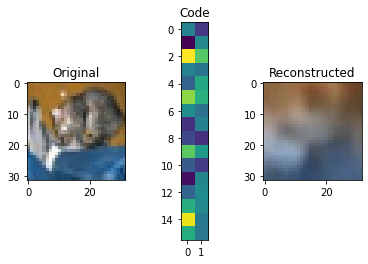

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


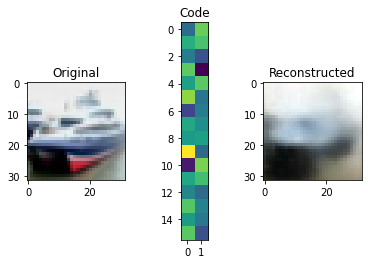

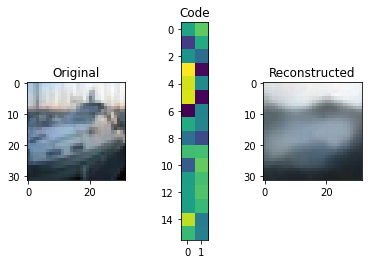

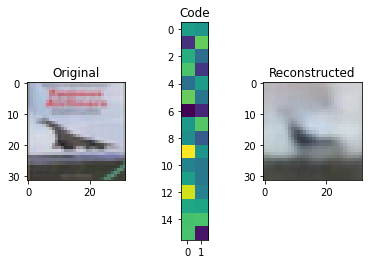

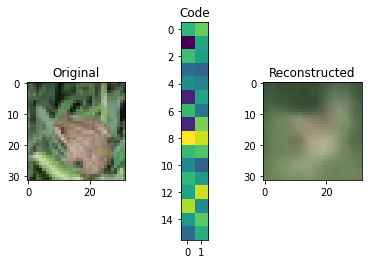

In [38]:
reconstruction_mse = autoencoder.evaluate(x_test_noisy, x_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = x_test[i]
    visualize(img,encoder,decoder)

In [40]:
images = x_train
codes = encoder.predict(images)

In [41]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [42]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [43]:
#distances,neighbors = get_similar(image,n_neighbors=7)

In [44]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=7)
    
    plt.figure(figsize=[15,10])
    plt.subplot(1,8,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(7):
        plt.subplot(1,8,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

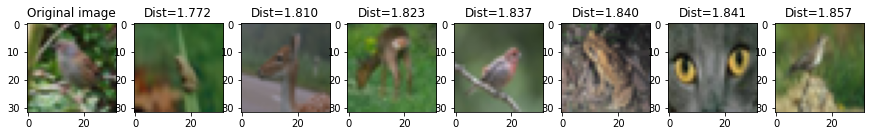

In [178]:
#show_similar(x_test[41])
show_similar(x_test[65])


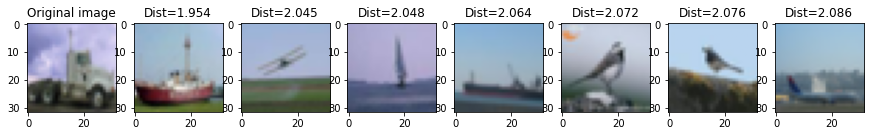

In [49]:
show_similar(x_test[209])

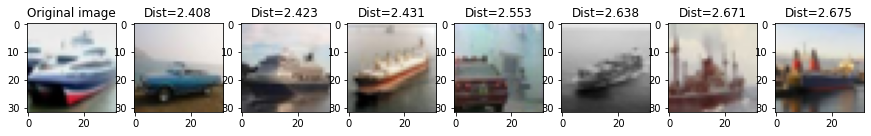

In [50]:
show_similar(x_test[1])

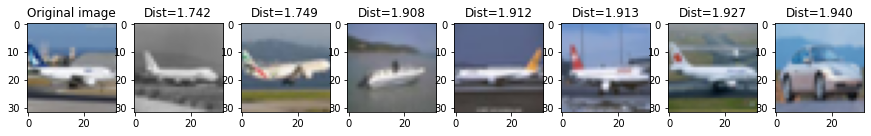

In [51]:
show_similar(x_test[90])

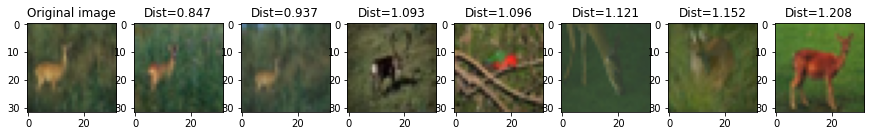

In [52]:
show_similar(x_test[236])

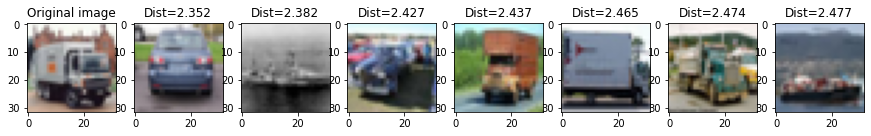

In [55]:
show_similar(x_test[11])

# Scoring

In [56]:
from keras.models import Model
from keras.models import load_model
from sklearn.metrics import label_ranking_average_precision_score

In [126]:
def compute_average_precision_score(test_codes, test_labels, learned_codes, y_train, n_samples):
    # For each n_samples (=number of retrieved images to assess) we store the corresponding labels and distances
    out_labels = []
    out_distances = []
    
    #For each query image feature we compute the closest images from training dataset
    for i in range(len(test_codes)):
        distances = []
        # Compute the euclidian distance for each feature from training dataset
        for code in learned_codes:
            distance = np.linalg.norm(code - test_codes[i])
            distances.append(distance)
        
        # Store the computed distances and corresponding labels from training dataset
        distances = np.array(distances)
        
        # Scoring function needs to replace similar labels by 1 and different ones by 0
        labels = np.copy(y_train).astype('float32')
        labels[labels != test_labels[i]] = -1
        labels[labels == test_labels[i]] = 1
        labels[labels == -1] = 0
        distance_with_labels = np.stack((distances, labels), axis=-1)
        sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]
        
        # The distances are between 0 and 28. The lesser the distance the bigger the relevance score should be
        sorted_distances = 28 - sorted_distance_with_labels[:, 0]
        sorted_labels = sorted_distance_with_labels[:, 1]
        
        # We keep only n_samples closest elements from the images retrieved
        out_distances.append(sorted_distances[:n_samples])
        out_labels.append(sorted_labels[:n_samples])

    out_labels = np.array(out_labels)
    out_labels_file_name = 'out_labels_{}'.format(n_samples)
    np.save(out_labels_file_name, out_labels)

    out_distances_file_name = 'out_distances_{}'.format(n_samples)
    out_distances = np.array(out_distances)
    np.save(out_distances_file_name, out_distances)
    
    # Score the model based on n_samples first images retrieved
    score = label_ranking_average_precision_score(out_labels, out_distances)
    scores.append(score)
    return score

In [154]:
# Array in which we will store computed scores
scores = []

# In order to save time on computations we keep only 1000 query images from test dataset 
n_test_samples = 100

# Each time we will score the first 10 retrieved images, then the first 50 etc...
n_train_samples = [10, 100]

#n_train_samples = [10, 50, 100, 200, 300, 400, 500, 750, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 20000, 30000, 40000, 50000, 60000]

In [110]:
learned_codes = encoder.predict(x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], x_train.shape[3]))

In [118]:
learned_codes2 = encoder.predict(x_train)

In [121]:
test_codes2 = encoder.predict(x_test)

In [130]:
test_codes2.shape

(10000, 32)

In [129]:
indexes = np.arange(len(y_test))
np.random.shuffle(indexes)
indexes = indexes[:n_test_samples]
#indexes

out_labels = []
out_distances = []

In [164]:
#For each query image feature we compute the closest images from training dataset
for i in range(len(test_codes2)):
    distances = []
    # Compute the euclidian distance for each feature from training dataset
    for code in learned_codes2:
        distance = np.linalg.norm(code - test_codes2[i])
        distances.append(distance)
    
    # Store the computed distances and corresponding labels from training dataset
    distances = np.array(distances)
    
    # Scoring function needs to replace similar labels by 1 and different ones by 0
    test_labels = y_test[indexes]
    #print(test_labels.shape)
    labels = np.copy(y_train).astype('float32')
    labels[labels != test_labels[i]] = -1
    labels[labels == test_labels[i]] = 1
    labels[labels == -1] = 0
    #print(distances)
    #print(distances.shape)
    labels = labels.flatten()
    #print(labels.shape)
    distance_with_labels = np.stack((distances, labels), axis=-1)
    sorted_distance_with_labels = distance_with_labels[distance_with_labels[:, 0].argsort()]
    
    # The distances are between 0 and 28. The lesser the distance the bigger the relevance score should be
    sorted_distances = 32 - sorted_distance_with_labels[:, 0]
    sorted_labels = sorted_distance_with_labels[:, 1]
    
    # We keep only n_samples closest elements from the images retrieved
    out_distances.append(sorted_distances[10])
    #print(sorted_distances[10])
    out_labels.append(sorted_labels[10])
    #print(sorted_labels[10])

score = label_ranking_average_precision_score(out_labels, out_distances)
print(score)
#out_labels = np.array(out_labels)
#out_labels_file_name = 'computed_data/out_labels_{}'.format(n_samples)
#np.save(out_labels_file_name, out_labels)

#out_distances_file_name = 'computed_data/out_distances_{}'.format(n_samples)
#out_distances = np.array(out_distances)
#np.save(out_distances_file_name, out_distances)

# Score the model based on n_samples first images retrieved
#score = label_ranking_average_precision_score(out_labels, out_distances)
#scores.append(score)

IndexError: ignored

(50000, 32)


IndexError: ignored

In [105]:
x_train.shape[0]

50000

In [106]:
x_train.shape[1]

32

In [107]:
x_train.shape[2]

32

In [109]:
x_train.shape[3]

3